# Overview
This notebook is used to investigate new lots.

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

from pptoolbox.platform import AutoML_v4, WAVELENGTHS_3NM_V1, preprocess
from pptoolbox.visualization import plot_spectra, plot_svp, spectral_vector_properties, plot_loadings, plot_scree, fit_pca, generate_pc_df

# Init

## load data and data check

In [2]:
pulldate = "250701"
datafolder = Path("../data/raw")

In [3]:
spectra = pd.read_csv(datafolder / f"spectra_{pulldate}.csv", index_col=0)
spectra.head()

,specimen_id,lot_name,date_scanned,analyser_id,company_id,product_id,product_name,raw_data,dark_ref_data,white_ref_data,dark_ref_scan_time,white_ref_scan_time
lot_id,,,,,,,,,,,,
77703,465059,ORT 23308102,1726489711,56,1086,6683,Orange Italy,"[{""wavelength"": 275.801513671875, ""reflectance...","[77.34491071428572, 76.704375, 80.931696428571...","[78.08549107142858, 77.70709821428571, 81.6610...",1726489657,1726489679
77703,465060,ORT 23308102,1726489762,56,1086,6683,Orange Italy,"[{""wavelength"": 275.801513671875, ""reflectance...","[77.34491071428572, 76.704375, 80.931696428571...","[78.08549107142858, 77.70709821428571, 81.6610...",1726489657,1726489679
77703,465061,ORT 23308102,1726489790,56,1086,6683,Orange Italy,"[{""wavelength"": 275.801513671875, ""reflectance...","[77.34491071428572, 76.704375, 80.931696428571...","[78.08549107142858, 77.70709821428571, 81.6610...",1726489657,1726489679
77703,465062,ORT 23308102,1726489820,56,1086,6683,Orange Italy,"[{""wavelength"": 275.801513671875, ""reflectance...","[77.34491071428572, 76.704375, 80.931696428571...","[78.08549107142858, 77.70709821428571, 81.6610...",1726489657,1726489679
77704,465063,ORT 23308103,1726489990,56,1086,6683,Orange Italy,"[{""wavelength"": 275.801513671875, ""reflectance...","[77.34491071428572, 76.704375, 80.931696428571...","[78.08549107142858, 77.70709821428571, 81.6610...",1726489657,1726489679


In [4]:
label = pd.read_csv(datafolder / f"label_{pulldate}.csv")

assert label["company_id"].nunique() == 1, "Multiple companies found in label data"
assert label["product_type_id"].nunique() == 1, "Multiple product types found in label data"
assert label["product_type_id"].nunique() == 1, "Multiple product types found in label data"

label = pd.pivot(label, index=["lot_id","lot_name"], columns="property_name", values="property_value").reset_index().set_index("lot_id")
print(label.isna().sum())
display(label.head())

property_name
lot_name               0
Brix uncorrected       0
Grade                  1
L star                 0
Supplier              36
TTA as citric acid     0
a star                 0
b star                 0
dtype: int64


property_name,lot_name,Brix uncorrected,Grade,L star,Supplier,TTA as citric acid,a star,b star
lot_id,,,,,,,,
77703,ORT 23308102,57.13,Borderline,42.79,ORT,7.06,0.19,28.56
77704,ORT 23308103,57.16,Borderline,43.68,ORT,6.91,1.09,31.22
77705,ORT 23433702,59.5,Pass,43.06,ORT,6.78,3.27,44.63
77706,ORT 23284901,56.99,Borderline,43.11,ORT,7.08,0.05,28.29
77707,AC 23397301,56.86,Pass,44.85,AC,7.07,1.6,38.52


In [5]:
# compare lot_id in spectra and label
spectra_lot_ids = set(spectra.index)
print(f"Number of spectra lot_ids: {len(spectra_lot_ids)}")
label_lot_ids = set(label.index)
print(f"Number of label lot_ids: {len(label_lot_ids)}")
missing_in_label = spectra_lot_ids - label_lot_ids
missing_in_spectra = label_lot_ids - spectra_lot_ids
if missing_in_label:
    print(f"Missing in label: {missing_in_label}")
    print(f"Number of missing in label: {len(missing_in_label)}")
if missing_in_spectra:
    print(f"Missing in spectra: {missing_in_spectra}")
    print(f"Number of missing in spectra: {len(missing_in_spectra)}")

Number of spectra lot_ids: 92
Number of label lot_ids: 67
Missing in label: {98439, 98446, 96527, 96528, 96529, 96530, 92949, 92950, 92951, 92952, 99742, 99743, 99744, 99745, 99746, 99748, 89667, 102999, 103000, 101847, 98523, 101855, 101856, 103391, 97124}
Number of missing in label: 25


In [6]:
spectra[spectra.index.isin(missing_in_label)].head(10)

,specimen_id,lot_name,date_scanned,analyser_id,company_id,product_id,product_name,raw_data,dark_ref_data,white_ref_data,dark_ref_scan_time,white_ref_scan_time
lot_id,,,,,,,,,,,,
89667,528415,FB 25035801,1738055082,56,1086,6683,Orange Italy,"[{""wavelength"": 275.801513671875, ""reflectance...","[77.60553571428571, 76.57714285714286, 80.8679...","[77.91892857142857, 76.97741071428571, 81.4377...",1738053813,1738053838
89667,528417,FB 25035801,1738055106,56,1086,6683,Orange Italy,"[{""wavelength"": 275.801513671875, ""reflectance...","[77.60553571428571, 76.57714285714286, 80.8679...","[77.91892857142857, 76.97741071428571, 81.4377...",1738053813,1738053838
89667,528419,FB 25035801,1738055155,56,1086,6683,Orange Italy,"[{""wavelength"": 275.801513671875, ""reflectance...","[77.60553571428571, 76.57714285714286, 80.8679...","[77.91892857142857, 76.97741071428571, 81.4377...",1738053813,1738053838
89667,528421,FB 25035801,1738055178,56,1086,6683,Orange Italy,"[{""wavelength"": 275.801513671875, ""reflectance...","[77.60553571428571, 76.57714285714286, 80.8679...","[77.91892857142857, 76.97741071428571, 81.4377...",1738053813,1738053838
92949,546304,CF 25115701,1741102216,56,1086,6683,Orange Italy,"[{""wavelength"": 275.801513671875, ""reflectance...","[78.21486607142857, 77.54584821428571, 81.4942...","[78.62058035714286, 77.69482142857143, 81.8747...",1741101794,1741102103
92949,546305,CF 25115701,1741102253,56,1086,6683,Orange Italy,"[{""wavelength"": 275.801513671875, ""reflectance...","[78.21486607142857, 77.54584821428571, 81.4942...","[78.62058035714286, 77.69482142857143, 81.8747...",1741101794,1741102103
92949,546306,CF 25115701,1741102280,56,1086,6683,Orange Italy,"[{""wavelength"": 275.801513671875, ""reflectance...","[78.21486607142857, 77.54584821428571, 81.4942...","[78.62058035714286, 77.69482142857143, 81.8747...",1741101794,1741102103
92949,546307,CF 25115701,1741102311,56,1086,6683,Orange Italy,"[{""wavelength"": 275.801513671875, ""reflectance...","[78.21486607142857, 77.54584821428571, 81.4942...","[78.62058035714286, 77.69482142857143, 81.8747...",1741101794,1741102103
92950,546308,AG 25115702,1741102346,56,1086,6683,Orange Italy,"[{""wavelength"": 275.801513671875, ""reflectance...","[78.21486607142857, 77.54584821428571, 81.4942...","[78.62058035714286, 77.69482142857143, 81.8747...",1741101794,1741102103


## previous model lot50

In [7]:
lot50_dataset = pd.read_csv(datafolder / "P2_lot50_label.csv")
lot50_dataset.head()

,Lot Name,b star,a star,L star,TTA as citric acid,Brix uncorrected
0,ORT 23308102,28.56,0.19,42.79,7.06,57.13
1,ORT 23308103,31.22,1.09,43.68,6.91,57.16
2,ORT 23433702,44.63,3.27,43.06,6.78,59.50
3,ORT 23284901,28.29,0.05,43.11,7.08,56.99
4,AC 23397301,38.52,1.60,44.85,7.07,56.86


In [8]:
train_sample_idx = label[label["lot_name"].isin(lot50_dataset["Lot Name"])].index
len(train_sample_idx)

50

In [9]:
test_sample_idx = label.index.difference(train_sample_idx)
len(test_sample_idx)

17

In [10]:
label[label.index.isin(test_sample_idx)]

property_name,lot_name,Brix uncorrected,Grade,L star,Supplier,TTA as citric acid,a star,b star
lot_id,,,,,,,,
77721,CF 24079801,57.56,Pass,48.03,CF,6.84,2.46,41.88
77722,FB 23273301,57.95,Pass,50.07,FB,6.9,3.9,43.85
77732,ORT 23404201,59.67,Pass,43.85,ORT,6.84,3.48,45.85
77978,AG 22548101,58.11,Fail,41.63,NaN,7.02,-3.48,29.03
77988,ORT 22412901,56.81,Critical,43.6,NaN,7.1,-1.4,27.33
77989,ORT 22425401,56.86,Borderline,44.11,NaN,7.1,-0.46,28.69
78713,CF 24035102,57.27,Pass,48.93,NaN,6.82,2.78,42.17
78714,CF 24247101,57.54,Pass,49.05,NaN,6.83,3.22,42.81
78715,CF 24247102,57.43,Pass,49.16,NaN,6.81,3.12,42.3


In [11]:
model_folder = Path("../models")

lot50_model_path = model_folder / "6104_P2_lot50/prediction"

models = {}

for model_file in lot50_model_path.glob("tasteprofile*.pkl"):
    print(f"Loading model: {model_file}")
    model_name = model_file.stem.split("_")[-1]
    models[model_name] = AutoML_v4.load(model_file, legacy=True)

Loading model: ..\models\6104_P2_lot50\prediction\tasteprofile_model_a star.pkl
Loading model: ..\models\6104_P2_lot50\prediction\tasteprofile_model_b star.pkl
Loading model: ..\models\6104_P2_lot50\prediction\tasteprofile_model_Brix uncorrected.pkl
Loading model: ..\models\6104_P2_lot50\prediction\tasteprofile_model_L star.pkl
Loading model: ..\models\6104_P2_lot50\prediction\tasteprofile_model_TTA as citric acid.pkl


In [12]:
models

{'a star': Pipeline(steps=[('SG1D', SavitzkyGolay(deriv=1, window=13)),
                 ('Scaler', StandardScaler(with_std=False)),
                 ('PCA', PCA(n_components=31, random_state=42)),
                 ('Lars', Lars(random_state=42))]),
 'b star': Pipeline(steps=[('SNV', SNV()), ('SG2D', SavitzkyGolay(deriv=2, window=7)),
                 ('Scaler', StandardScaler(with_std=False)),
                 ('PCA', PCA(n_components=25, random_state=42)),
                 ('Lars', Lars(random_state=42))]),
 'Brix uncorrected': Pipeline(steps=[('SNV', SNV()), ('SG1D', SavitzkyGolay(deriv=1, window=15)),
                 ('Scaler', StandardScaler(with_std=False)),
                 ('PCA', PCA(n_components=17, random_state=42)),
                 ('Lars', Lars(random_state=42))]),
 'L star': Pipeline(steps=[('SNV', SNV()), ('SG1D', SavitzkyGolay(deriv=1, window=13)),
                 ('Scaler', StandardScaler(with_std=False)),
                 ('SVR', SVR(C=983.5444010615668, kernel='li

## set up y_all

In [13]:
y_all = spectra[["lot_name","specimen_id","date_scanned"]]
print(f"Number of samples in y_all: {len(y_all)}")
print(f"Number of unique lots in y_all: {y_all.index.nunique()}")

Number of samples in y_all: 372
Number of unique lots in y_all: 92


In [14]:
y_all = pd.merge(y_all, label.drop(columns=['lot_name']), left_index=True, right_index=True, how="left")

In [15]:
y_all["set"] = "test"
y_all.loc[y_all.index.isin(train_sample_idx), "set"] = "train"
y_all.loc[y_all.index.isin(test_sample_idx), "set"] = "val"
y_all["set"].value_counts()

train    200
test     104
val       68
Name: set, dtype: int64

In [16]:
# assign "unknown" to all Na values in y_all
y_all.fillna("unknown", inplace=True)
y_all.isna().sum()

lot_name              0
specimen_id           0
date_scanned          0
Brix uncorrected      0
Grade                 0
L star                0
Supplier              0
TTA as citric acid    0
a star                0
b star                0
set                   0
dtype: int64

## lots to investigate

In [17]:
sus_lot_names = ['25115701', '25233501', '25233502']

# which lot ids have lot names similar to above
sus_lot_ids = set(y_all[y_all["lot_name"].str.contains('|'.join(sus_lot_names))].index)
print(f"Number of suspicious lot ids: {len(sus_lot_ids)}")
print(f"Suspicious lot ids: {sus_lot_ids}")

y_all[y_all.index.isin(sus_lot_ids)]

Number of suspicious lot ids: 3
Suspicious lot ids: {99744, 92949, 99743}


,lot_name,specimen_id,date_scanned,Brix uncorrected,Grade,L star,Supplier,TTA as citric acid,a star,b star,set
lot_id,,,,,,,,,,,
92949,CF 25115701,546304,1741102216,unknown,unknown,unknown,unknown,unknown,unknown,unknown,test
92949,CF 25115701,546305,1741102253,unknown,unknown,unknown,unknown,unknown,unknown,unknown,test
92949,CF 25115701,546306,1741102280,unknown,unknown,unknown,unknown,unknown,unknown,unknown,test
92949,CF 25115701,546307,1741102311,unknown,unknown,unknown,unknown,unknown,unknown,unknown,test
99743,FB CC 25233501,585772,1747296949,unknown,unknown,unknown,unknown,unknown,unknown,unknown,test
99743,FB CC 25233501,585775,1747296998,unknown,unknown,unknown,unknown,unknown,unknown,unknown,test
99743,FB CC 25233501,585777,1747297021,unknown,unknown,unknown,unknown,unknown,unknown,unknown,test
99743,FB CC 25233501,585779,1747297043,unknown,unknown,unknown,unknown,unknown,unknown,unknown,test
99744,FB CC 25233502,585781,1747297081,unknown,unknown,unknown,unknown,unknown,unknown,unknown,test


# X-eda

In [18]:
X_all, _ = preprocess(X_input=spectra.reset_index(), wavelengths=WAVELENGTHS_3NM_V1)

In [19]:
X_all

,480.0,483.0,486.0,489.0,492.0,495.0,498.0,501.0,504.0,507.0,...,1023.0,1026.0,1029.0,1032.0,1035.0,1038.0,1041.0,1044.0,1047.0,1050.0
lot_id,,,,,,,,,,,,,,,,,,,,,
77703,4.983275,4.999198,5.023006,5.044474,5.076964,5.111064,5.158284,5.219969,5.315032,5.382012,...,10.130960,10.260709,10.351074,10.460510,10.599068,10.718978,10.822336,10.925198,11.052090,11.161763
77703,4.901524,4.916192,4.937824,4.960287,4.989257,5.030516,5.076320,5.147042,5.219462,5.297657,...,10.362039,10.497778,10.624571,10.753762,10.867591,10.967010,11.088793,11.224750,11.322750,11.422525
77703,4.869310,4.892811,4.910817,4.937686,4.971402,5.009403,5.061289,5.121439,5.207785,5.278440,...,10.193529,10.371429,10.420187,10.508749,10.652533,10.779111,10.875395,10.951895,11.103351,11.210600
77703,4.938551,4.957977,4.980376,5.005394,5.037995,5.072407,5.119286,5.188015,5.269432,5.349102,...,10.109549,10.255374,10.332237,10.452451,10.588850,10.689090,10.795009,10.909787,11.024476,11.104042
77704,4.852503,4.871979,4.899420,4.922794,4.955251,4.986243,5.033756,5.103855,5.182488,5.253915,...,9.948863,10.066293,10.153344,10.268971,10.385631,10.490104,10.577309,10.671388,10.784584,10.848914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103000,4.643623,4.657210,4.675390,4.712196,4.756029,4.812866,4.878718,4.982284,5.099906,5.245116,...,9.420325,9.480843,9.598250,9.704990,9.791564,9.896856,9.989385,10.051478,10.159737,10.227712
103391,4.795813,4.814299,4.841966,4.877522,4.920151,4.974199,5.041604,5.134357,5.244972,5.366835,...,9.354314,9.445106,9.525558,9.631465,9.726430,9.805088,9.902804,10.011913,10.099780,10.209916
103391,4.813005,4.831696,4.850418,4.890287,4.933528,4.986900,5.055141,5.147608,5.254355,5.384665,...,9.822520,9.927608,10.019687,10.146179,10.258905,10.359904,10.507992,10.566240,10.700230,10.829461


In [20]:
param_label_map = {}

for col in y_all.columns:
    if col in ['lot_name','date_scanned','specimen_id']:
        continue
    elif y_all[col].dtype == 'float64':
        param_label_map[col] = 'reg'
    elif y_all[col].dtype == 'object':
        param_label_map[col] = 'clf'
    elif col == 'scan_month':
        param_label_map[col] = 'clf'

param_label_map = {k: v for k, v in param_label_map.items() if k == 'set'}

print(param_label_map)

{'set': 'clf'}


In [21]:
# check if X_all and y_all have the same index
assert X_all.index.equals(y_all.index), "X_all and y_all do not have the same index"

## No Preprocessing

(372, 191) (372, 11)


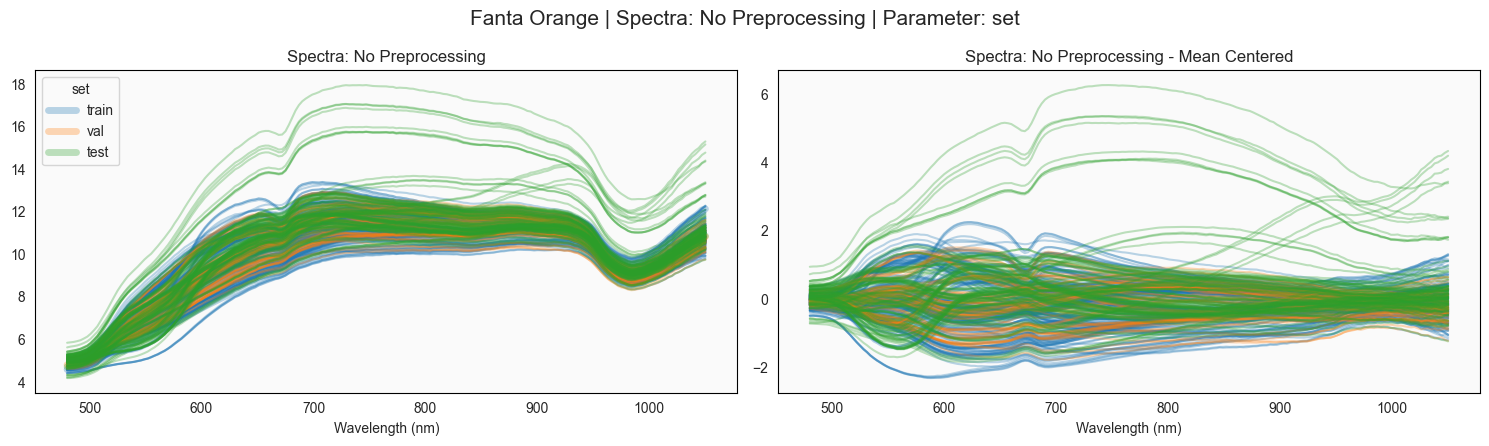

In [23]:
SAMPLE_TYPE = 'Fanta Orange'
PREPROCESSING = 'No Preprocessing'

selected_df = X_all.copy()
selected_labels = y_all.copy()

print(selected_df.shape, selected_labels.shape)

plot_df = selected_df.copy()

for param, label_type in param_label_map.items():

    if param == 'set':
        desired_order = ['train', 'val', 'test']
        selected_labels[param] = pd.Categorical(selected_labels[param], categories=desired_order, ordered=True)
    

    try:
        plot_spectra(plot_df, labels=selected_labels[[param]],
                    label_type=label_type,
                    spec_prep=PREPROCESSING,
                    sample_type=SAMPLE_TYPE,
                    # cmap=cmap
                    )
    except Exception as e:
        print(f"Error in plotting spectra for {param}")

    plt.show()

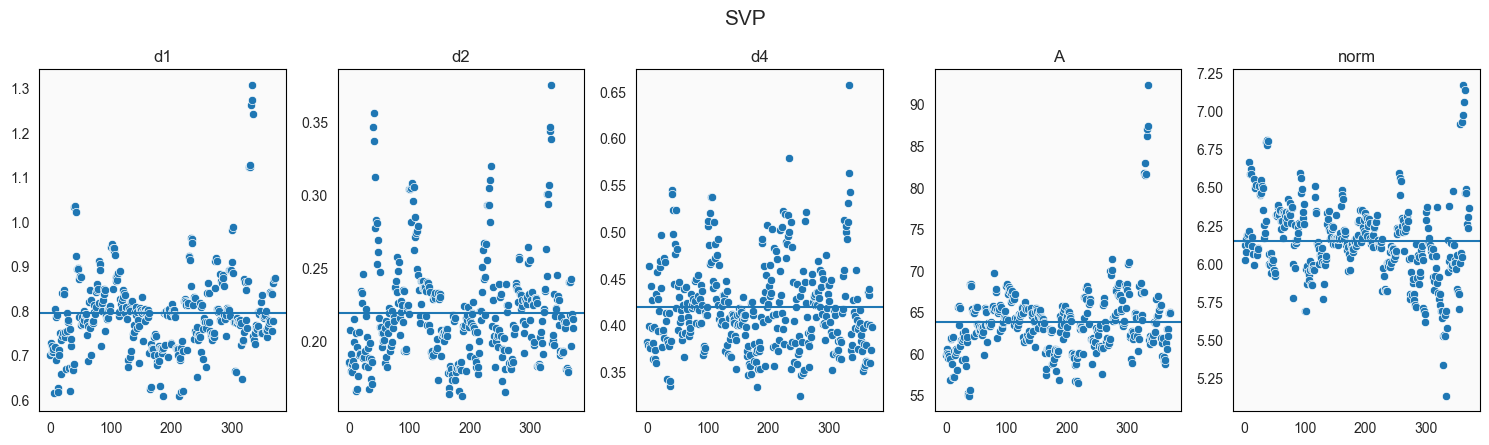

In [23]:
plot_svp(plot_df)

In [24]:
selections = {
    'X_all':{
        'raw_df': X_all,
        'label_df': y_all,
    }
}

#metrics cutoff
metrics = {
    0 : 'd1',
    1 : 'd2',
    2 : 'd4',
    3 : 'A',
    4 : 'norm'
}

for selection in selections:
    if selection == 'X_all':
        selections[selection]['choice'] = 4
        selections[selection]['maxval'] = 6.9
        selections[selection]['minval'] = 5.5
        selections[selection]['outliers'] = list(sus_lot_ids)

(372, 191) (372, 11)
False    354
True      18
Name: norm, dtype: int64
Number of samples outside the range: 18


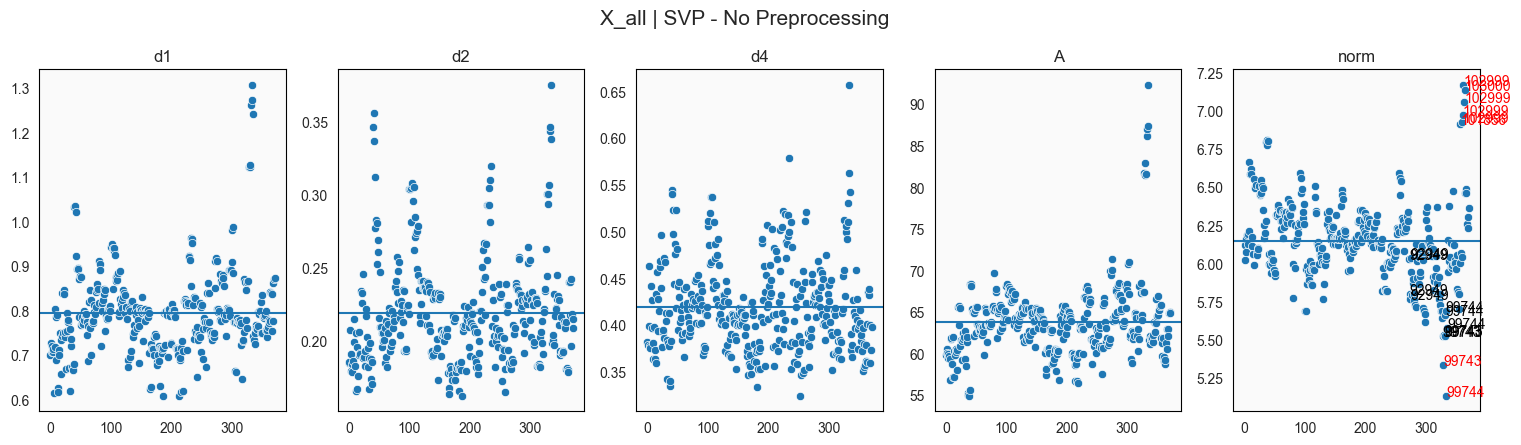

In [25]:
for selection in selections:
    choice = selections[selection]['choice']
    minval = selections[selection]['minval']
    maxval = selections[selection]['maxval']
    outliers = selections[selection]['outliers']

    selected_df = selections[selection]['raw_df']
    selected_labels = selections[selection]['label_df']

    print(selected_df.shape, selected_labels.shape)

    plot_svp(selected_df, title=f'{selection} | SVP - No Preprocessing')

    svp_arr = spectral_vector_properties(selected_df, True)

    norm_data = svp_arr[metrics[choice]]

    anomalous_mask = (svp_arr[metrics[choice]] < minval) | (svp_arr[metrics[choice]] > maxval) | svp_arr.index.isin(outliers)
    print(anomalous_mask.value_counts())

    norm_ax = plt.gcf().axes[choice]

    count = 0

    for idx in range(len(norm_data)):
        if norm_data.iloc[idx] < minval or norm_data.iloc[idx] > maxval:  
            norm_ax.text(idx, norm_data.iloc[idx], norm_data.index[idx], 
                        fontsize=10, color='red')
            count += 1
        elif norm_data.index[idx] in outliers:
            norm_ax.text(idx, norm_data.iloc[idx], norm_data.index[idx], 
                        fontsize=10, color='black')
            count += 1

    print(f"Number of samples outside the range: {count}")
            
    plt.show()
    plt.close()

Processing X_all dataset
(372, 191) (372, 11)
False    354
True      18
Name: norm, dtype: int64


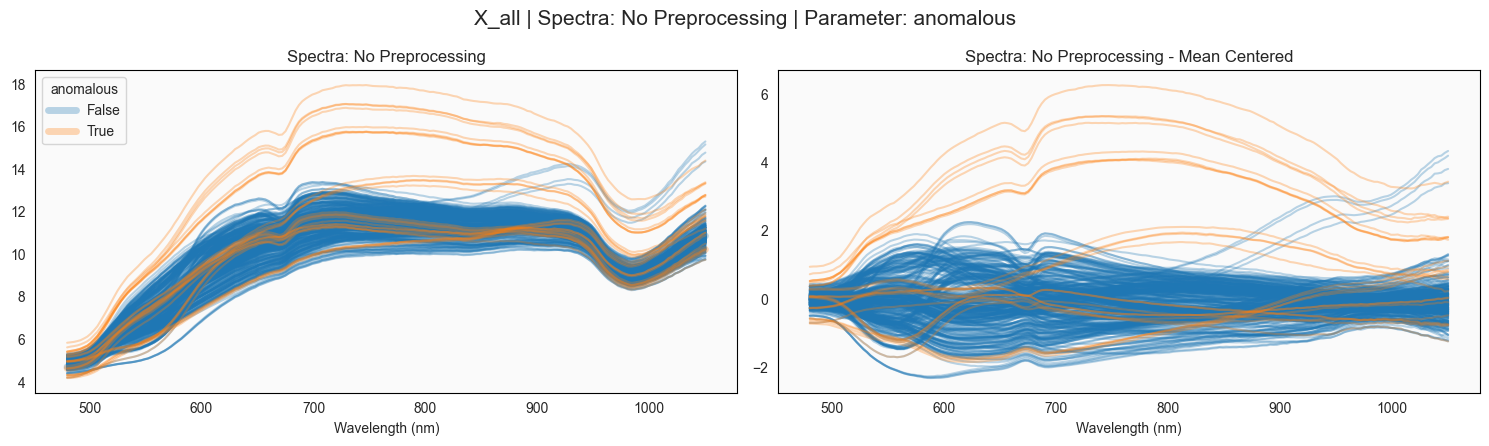

In [26]:
for selection in selections:
    SAMPLE_TYPE = f'{selection}'

    choice = selections[selection]['choice']
    minval = selections[selection]['minval']
    maxval = selections[selection]['maxval']
    outliers = selections[selection]['outliers']

    print(f'Processing {selection} dataset')
    selected_df = selections[selection]['raw_df']
    selected_labels = selections[selection]['label_df']
    print(selected_df.shape, selected_labels.shape)

    svp_arr = spectral_vector_properties(selected_df, True)

    anomalous_mask = (svp_arr[metrics[choice]] < minval) | (svp_arr[metrics[choice]] > maxval) | svp_arr.index.isin(outliers)
    print(anomalous_mask.value_counts())

    # add a new column in check_df to label anomalous samples
    check_df = selected_df.copy(deep=True)
    check_df['anomalous'] = anomalous_mask
    # display(check_df[check_df['anomalous'] == True])

    plot_spectra(selected_df, labels=check_df[['anomalous']],
                spec_prep=PREPROCESSING,
                sample_type=SAMPLE_TYPE,
                # cmap=cmap
                )
    # plt.savefig(f"../data/visualisation/{selection}_anomalous_spectra.png")
    plt.show()
    plt.close()


Processing X_all dataset
(372, 191) (372, 11)


,lot_name,specimen_id,date_scanned,Brix uncorrected,Grade,L star,Supplier,TTA as citric acid,a star,b star,set
lot_id,,,,,,,,,,,
92949,CF 25115701,546304,1741102216,unknown,unknown,unknown,unknown,unknown,unknown,unknown,new
92949,CF 25115701,546305,1741102253,unknown,unknown,unknown,unknown,unknown,unknown,unknown,new
92949,CF 25115701,546306,1741102280,unknown,unknown,unknown,unknown,unknown,unknown,unknown,new
92949,CF 25115701,546307,1741102311,unknown,unknown,unknown,unknown,unknown,unknown,unknown,new
99743,FB CC 25233501,585772,1747296949,unknown,unknown,unknown,unknown,unknown,unknown,unknown,new
99743,FB CC 25233501,585775,1747296998,unknown,unknown,unknown,unknown,unknown,unknown,unknown,new
99743,FB CC 25233501,585777,1747297021,unknown,unknown,unknown,unknown,unknown,unknown,unknown,new
99743,FB CC 25233501,585779,1747297043,unknown,unknown,unknown,unknown,unknown,unknown,unknown,new
99744,FB CC 25233502,585781,1747297081,unknown,unknown,unknown,unknown,unknown,unknown,unknown,new


Number of anomalous samples: 18


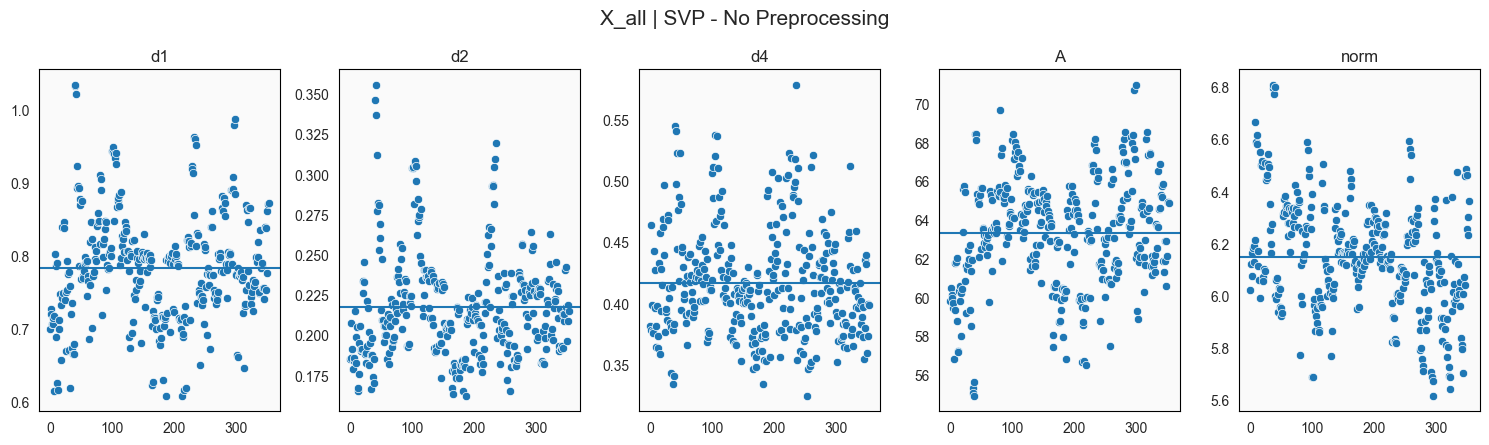

shapes after cleaning: (354, 191) (354, 11)


In [ ]:
for selection in selections:

    choice = selections[selection]['choice']
    minval = selections[selection]['minval']
    maxval = selections[selection]['maxval']
    outliers = selections[selection]['outliers']

    # output_dir = Path(f"../data/processed/")
    # output_dir.mkdir(exist_ok=True, parents=True)

    print(f'\nProcessing {selection} dataset')
    selected_df = selections[selection]['raw_df']
    selected_labels = selections[selection]['label_df']
    print(selected_df.shape, selected_labels.shape)

    svp_arr = spectral_vector_properties(selected_df, True)

    anomalous_mask = (svp_arr[metrics[choice]] < minval) | (svp_arr[metrics[choice]] > maxval) | svp_arr.index.isin(outliers)
    
    cleaned_df = selected_df[~anomalous_mask]
    cleaned_labels = selected_labels[~anomalous_mask]

    display(selected_labels[anomalous_mask])

    count = 0

    print(f'Number of anomalous samples: {anomalous_mask.sum() + count}')
    
    SAMPLE_TYPE = f'{selection}'
    plot_svp(cleaned_df, title=f'{selection} | SVP - No Preprocessing')
    plt.show()
    plt.close()

    print(f'shapes after cleaning: {cleaned_df.shape} {cleaned_labels.shape}')

    # cleaned_df.to_csv(output_dir/f"{selection}/cleaned_input.csv")
    # cleaned_labels.to_csv(output_dir/f"{selection}/cleaned_label.csv")

In [40]:
selected_labels[anomalous_mask].drop_duplicates(subset=['lot_name'])[['lot_name']]

,lot_name
lot_id,
92949,CF 25115701
99743,FB CC 25233501
99744,FB CC 25233502
101856,AG 25255601
102999,AC 25275901
103000,FB 25273301


## With Preprocessing

In [28]:
models

{'a star': Pipeline(steps=[('SG1D', SavitzkyGolay(deriv=1, window=13)),
                 ('Scaler', StandardScaler(with_std=False)),
                 ('PCA', PCA(n_components=31, random_state=42)),
                 ('Lars', Lars(random_state=42))]),
 'b star': Pipeline(steps=[('SNV', SNV()), ('SG2D', SavitzkyGolay(deriv=2, window=7)),
                 ('Scaler', StandardScaler(with_std=False)),
                 ('PCA', PCA(n_components=25, random_state=42)),
                 ('Lars', Lars(random_state=42))]),
 'Brix uncorrected': Pipeline(steps=[('SNV', SNV()), ('SG1D', SavitzkyGolay(deriv=1, window=15)),
                 ('Scaler', StandardScaler(with_std=False)),
                 ('PCA', PCA(n_components=17, random_state=42)),
                 ('Lars', Lars(random_state=42))]),
 'L star': Pipeline(steps=[('SNV', SNV()), ('SG1D', SavitzkyGolay(deriv=1, window=13)),
                 ('Scaler', StandardScaler(with_std=False)),
                 ('SVR', SVR(C=983.5444010615668, kernel='li

In [29]:
prepro_pipeline = Pipeline(models['a star'].steps[:-2])
prepro_pipeline

Pipeline(steps=[('SG1D', SavitzkyGolay(deriv=1, window=13)),
                ('Scaler', StandardScaler(with_std=False))])

In [30]:
window_length = prepro_pipeline.named_steps['SG1D'].get_params()['window']
if window_length % 2 == 0:
    window_length += 1  # Ensure odd window length for Savitzky-Golay filter
window_cut = window_length // 2

In [31]:
X_all_processed = pd.DataFrame(prepro_pipeline.transform(X_all), index=X_all.index, columns=X_all.columns[window_cut:-window_cut])

In [32]:
X_all_processed

,498.0,501.0,504.0,507.0,510.0,513.0,516.0,519.0,522.0,525.0,...,1005.0,1008.0,1011.0,1014.0,1017.0,1020.0,1023.0,1026.0,1029.0,1032.0
lot_id,,,,,,,,,,,,,,,,,,,,,
77703,-0.008881,-0.013661,-0.019153,-0.026139,-0.034384,-0.042036,-0.050665,-0.055913,-0.060639,-0.060991,...,0.007602,0.007950,0.008414,0.011606,0.013826,0.012228,0.012251,0.013235,0.013528,0.014423
77703,-0.009409,-0.014327,-0.020677,-0.027805,-0.035061,-0.043090,-0.049589,-0.054977,-0.058021,-0.059375,...,0.011145,0.014809,0.017163,0.019000,0.021562,0.024573,0.025429,0.023043,0.020848,0.020791
77703,-0.008293,-0.013449,-0.019125,-0.026902,-0.035019,-0.042652,-0.050429,-0.055243,-0.059569,-0.059672,...,0.013230,0.010924,0.006439,0.011044,0.014613,0.013419,0.013247,0.013251,0.013466,0.010588
77703,-0.008584,-0.013416,-0.018771,-0.025792,-0.032767,-0.040183,-0.048597,-0.054269,-0.058953,-0.060211,...,0.007164,0.005916,0.005350,0.008722,0.011364,0.011666,0.014232,0.014108,0.013114,0.013816
77704,-0.010124,-0.015405,-0.021223,-0.027481,-0.034847,-0.042501,-0.051099,-0.056937,-0.060861,-0.061911,...,0.003719,0.002936,0.001806,0.002668,0.002455,0.001650,0.002796,0.003429,0.004765,0.005254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103000,0.012516,0.016170,0.020893,0.025970,0.032226,0.036575,0.038550,0.037975,0.034586,0.029743,...,-0.005883,-0.007101,-0.007480,-0.011143,-0.014641,-0.015188,-0.014056,-0.010620,-0.005074,-0.004726
103391,0.009973,0.009896,0.010136,0.009976,0.008791,0.005198,-0.000152,-0.004496,-0.010261,-0.015565,...,-0.011117,-0.013257,-0.016141,-0.017230,-0.019471,-0.019080,-0.019470,-0.017879,-0.015646,-0.011912
103391,0.009912,0.010323,0.011407,0.011117,0.010765,0.007105,0.002552,-0.001846,-0.007744,-0.012923,...,-0.000879,-0.002670,-0.004443,-0.004176,-0.005421,-0.004346,-0.002889,-0.002376,0.004133,0.007336


In [33]:
datasets = {
    'X_all': {
        'X_all': X_all,
        'y_all': y_all,
        'param_label_map': param_label_map,
        'plot_df': X_all_processed,
    }
}

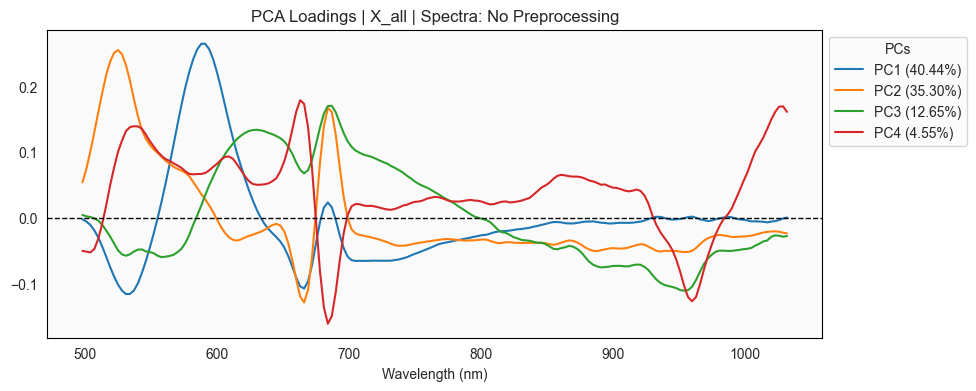

Total Explained Variance: 92.944% 
    Number of Components: 4


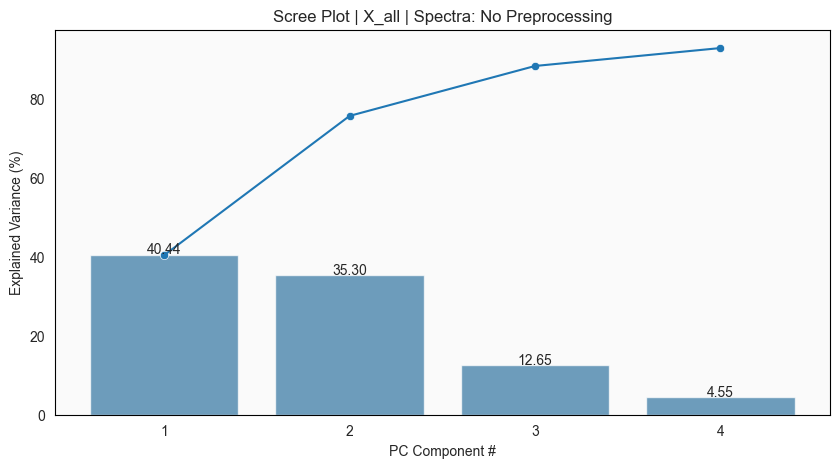

In [42]:
N_COMP = 0.90
RANDOM_STATE = 42

for dataset in datasets:

    output_dir = Path(f"../data/visualisation/{dataset}/{PREPROCESSING}")
    output_dir.mkdir(exist_ok=True, parents=True)
    
    SAMPLE_TYPE = f'{dataset}'

    plot_df = datasets[dataset]['plot_df']

    fitted_pc, pc_labels = fit_pca(plot_df, N_COMP, RANDOM_STATE)

    datasets[dataset]['fitted_pc'] = fitted_pc
    datasets[dataset]['pc_labels'] = pc_labels

    fig2, ax2 = plot_loadings(plot_df, fitted_pc, pc_labels, 
                            spec_prep=PREPROCESSING, 
                            sample_type=SAMPLE_TYPE)
    
    plt.show()
    plt.close()

    fig1, ax1 = plot_scree(fitted_pc,
                        spec_prep=PREPROCESSING, 
                        sample_type=SAMPLE_TYPE)
    print(f"""Total Explained Variance: {fitted_pc.explained_variance_ratio_.sum()*100:.3f}% 
    Number of Components: {len(fitted_pc.explained_variance_ratio_)}""")

    plt.show()
    plt.close()


Processing X_all dataset
(372, 179) (372, 11)
Generating figure for set


c:\Users\RyanSoh\miniconda3\envs\latest\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Detected 4 PCA-based outliers and 12 predefined outliers
Combined outliers: 12
Unique outlier lot names: ['CF 25115701', 'FB CC 25233502', 'FB CC 25233501']


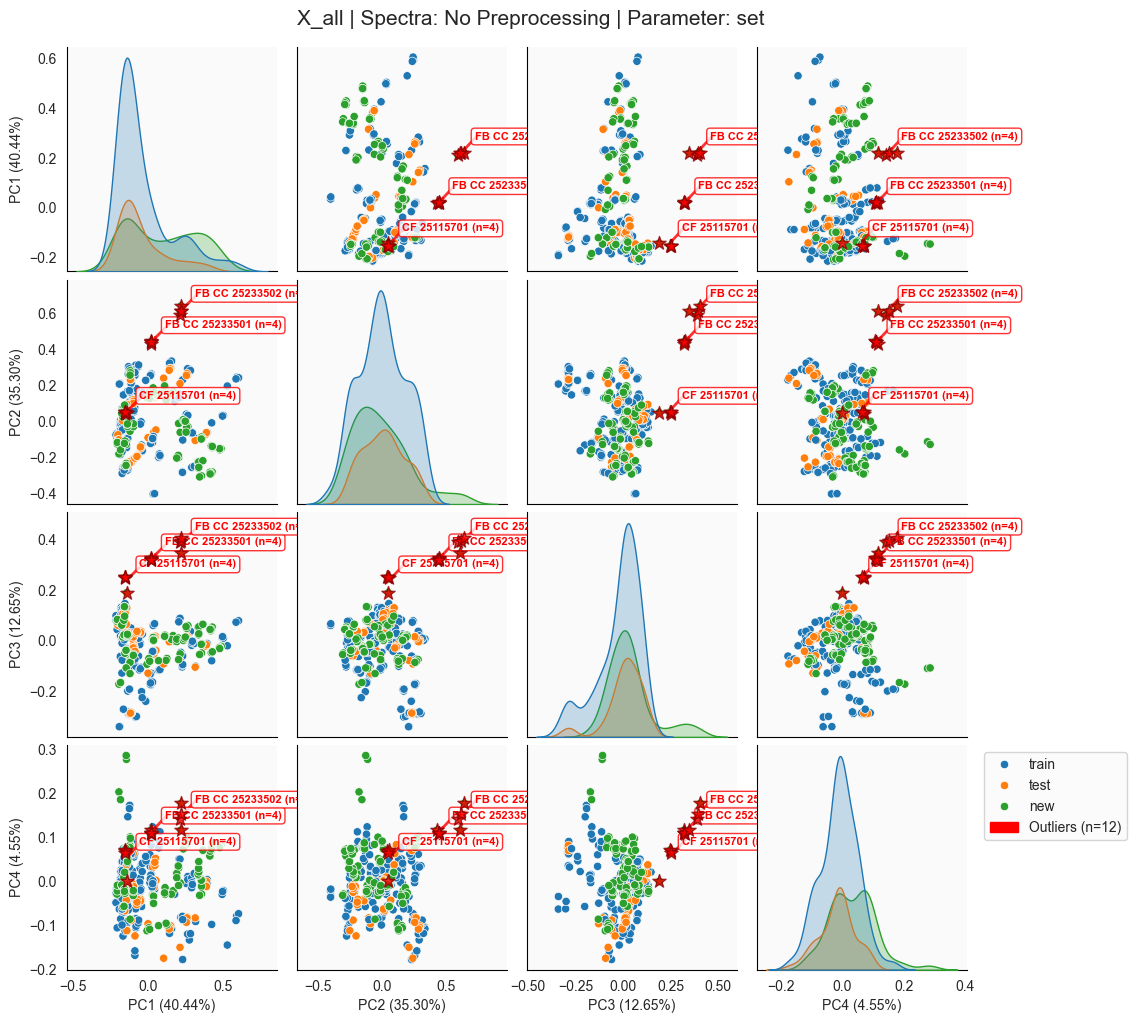

In [43]:
from scipy.spatial.distance import cdist
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as mpatches

def detect_pca_outliers(pc_df, n_components=5, outlier_threshold=95):
    """
    Detect outliers based on PCA distance from the centroid
    """
    # Get PC columns (excluding non-PC columns like 'set', 'lot_name', etc.)
    pc_cols = [col for col in pc_df.columns if col.startswith('PC')]
    
    # Use first n_components for outlier detection
    n_pc_to_use = min(n_components, len(pc_cols))
    pc_data = pc_df[pc_cols[:n_pc_to_use]]
    
    # Calculate centroid
    centroid = pc_data.mean().values.reshape(1, -1)
    
    # Calculate distances from centroid
    distances = cdist(pc_data.values, centroid, metric='euclidean').flatten()
    
    # Define outliers as samples beyond the threshold percentile
    threshold = np.percentile(distances, outlier_threshold)
    outlier_mask = distances > threshold
    
    return outlier_mask, distances

def get_unique_lot_positions(outlier_data, selected_labels, pc_cols):
    """
    Get unique lot positions for labeling to avoid duplicate labels
    Returns a dictionary with lot_name as key and representative coordinates as value
    """
    unique_lots = {}
    
    for idx, row in outlier_data.iterrows():
        # Get lot name (handle both Series and scalar cases)
        lot_name_raw = selected_labels.loc[idx, 'lot_name']
        if hasattr(lot_name_raw, 'iloc'):
            lot_name = lot_name_raw.iloc[0] if len(lot_name_raw) > 0 else 'Unknown'
        else:
            lot_name = lot_name_raw
        lot_name = str(lot_name)
        
        # Get PC coordinates
        x_pos = float(row[pc_cols[0]] if hasattr(row[pc_cols[0]], '__float__') else row[pc_cols[0]].iloc[0])
        y_pos = float(row[pc_cols[1]] if hasattr(row[pc_cols[1]], '__float__') else row[pc_cols[1]].iloc[0])
        
        if lot_name not in unique_lots:
            unique_lots[lot_name] = {'x_coords': [], 'y_coords': [], 'indices': []}
        
        unique_lots[lot_name]['x_coords'].append(x_pos)
        unique_lots[lot_name]['y_coords'].append(y_pos)
        unique_lots[lot_name]['indices'].append(idx)
    
    # Calculate centroid for each lot (average position of all samples from that lot)
    lot_positions = {}
    for lot_name, coords in unique_lots.items():
        avg_x = np.mean(coords['x_coords'])
        avg_y = np.mean(coords['y_coords'])
        lot_positions[lot_name] = {
            'x': avg_x, 
            'y': avg_y,
            'count': len(coords['indices']),
            'indices': coords['indices']
        }
    
    return lot_positions

for dataset in datasets:
    SAMPLE_TYPE = f'{dataset}'
    print(f'\nProcessing {dataset} dataset')
    
    selected_df = datasets[dataset]['X_all']
    selected_labels = datasets[dataset]['y_all']
    param_label_map = datasets[dataset]['param_label_map']
    plot_df = datasets[dataset]['plot_df']
    fitted_pc = datasets[dataset]['fitted_pc']
    pc_labels = datasets[dataset]['pc_labels']

    print(plot_df.shape, selected_labels.shape)

    for param in param_label_map.keys():
        # check if png exists
        if (output_dir / f"{dataset}_pca_{param}.png").exists():
            print(f"Skipping {dataset} {param}")
            continue
        
        print(f'Generating figure for {param}')
        pc_df = generate_pc_df(plot_df, fitted_pc, pc_labels, labels=selected_labels[[param]])
        
        # Get PC columns (excluding non-PC columns)
        pc_cols = [col for col in pc_df.columns if col.startswith('PC')]
        
        # Detect PCA-based outliers
        pca_outlier_mask, pca_distances = detect_pca_outliers(pc_df, n_components=5, outlier_threshold=99)
        
        # Add predefined suspicious lots to outlier mask
        predefined_outliers = pc_df.index.isin(sus_lot_ids)
        combined_outlier_mask = pca_outlier_mask | predefined_outliers
        
        # Create the pairplot
        g = sns.pairplot(data=pc_df.reset_index().drop('lot_id', axis=1), hue=param)
        g.fig.suptitle(f'{SAMPLE_TYPE} | Spectra: {PREPROCESSING} | Parameter: {param}', y=1.02, size=15)
        
        # Add outlier annotations to each subplot
        n_pc = len(pc_cols)
        
        for i in range(n_pc):
            for j in range(n_pc):
                ax = g.axes[i, j]
                
                if i != j:  # Only annotate scatter plots, not diagonal plots
                    # Get outlier data for this subplot
                    outlier_data = pc_df[combined_outlier_mask]
                    
                    if len(outlier_data) > 0:
                        x_col = pc_cols[j]  # x-axis corresponds to column j
                        y_col = pc_cols[i]  # y-axis corresponds to row i
                        
                        # Plot outliers with red markers
                        ax.scatter(outlier_data[x_col], outlier_data[y_col], 
                                 color='red', s=100, alpha=0.8, marker='*', 
                                 edgecolors='darkred', linewidth=1, zorder=10)
                        
                        # Get unique lot positions for current subplot
                        current_pc_cols = [x_col, y_col]
                        lot_positions = get_unique_lot_positions(outlier_data, selected_labels, current_pc_cols)
                        
                        # Add arrows and labels for unique lots only
                        for lot_name, pos_info in lot_positions.items():
                            x_pos = pos_info['x']
                            y_pos = pos_info['y']
                            sample_count = pos_info['count']
                            
                            # Calculate offset for arrow to avoid overlap
                            x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
                            y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
                            
                            # Add arrow pointing to the outlier
                            arrow = FancyArrowPatch((x_pos + 0.1 * x_range, y_pos + 0.1 * y_range),
                                                  (x_pos, y_pos),
                                                  arrowstyle='->', 
                                                  color='red', 
                                                  linewidth=2,
                                                  alpha=0.8)
                            ax.add_patch(arrow)
                            
                            # Add lot name label with sample count if > 1
                            label_text = f'{lot_name}' if sample_count == 1 else f'{lot_name} (n={sample_count})'
                            ax.annotate(label_text, 
                                      xy=(x_pos, y_pos),
                                      xytext=(10, 10), 
                                      textcoords='offset points',
                                      bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                               edgecolor='red', alpha=0.8),
                                      fontsize=8, 
                                      color='red',
                                      weight='bold')
        
        # Add custom legend for outliers
        if hasattr(g, '_legend') and g._legend:
            outlier_patch = mpatches.Patch(color='red', label=f'Outliers (n={combined_outlier_mask.sum()})')
            handles = g._legend.legend_handles + [outlier_patch]
            labels = [t.get_text() for t in g._legend.texts] + [f'Outliers (n={combined_outlier_mask.sum()})']
            g._legend.remove()
            plt.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left')
        
        print(f'Detected {pca_outlier_mask.sum()} PCA-based outliers and {predefined_outliers.sum()} predefined outliers')
        print(f'Combined outliers: {combined_outlier_mask.sum()}')
        if combined_outlier_mask.sum() > 0:
            outlier_lots = selected_labels.loc[pc_df.index[combined_outlier_mask], 'lot_name'].tolist()
            # Get unique lot names for summary
            unique_outlier_lots = list(set([str(lot) for lot in outlier_lots]))
            print(f'Unique outlier lot names: {unique_outlier_lots}')

        plt.show()
        plt.close()


=== Detailed Outlier Analysis for X_all ===
Analyzing thresholds: [98.5]%, Primary threshold: 95%
Highlighting outliers at: 98.5% (most lenient threshold)


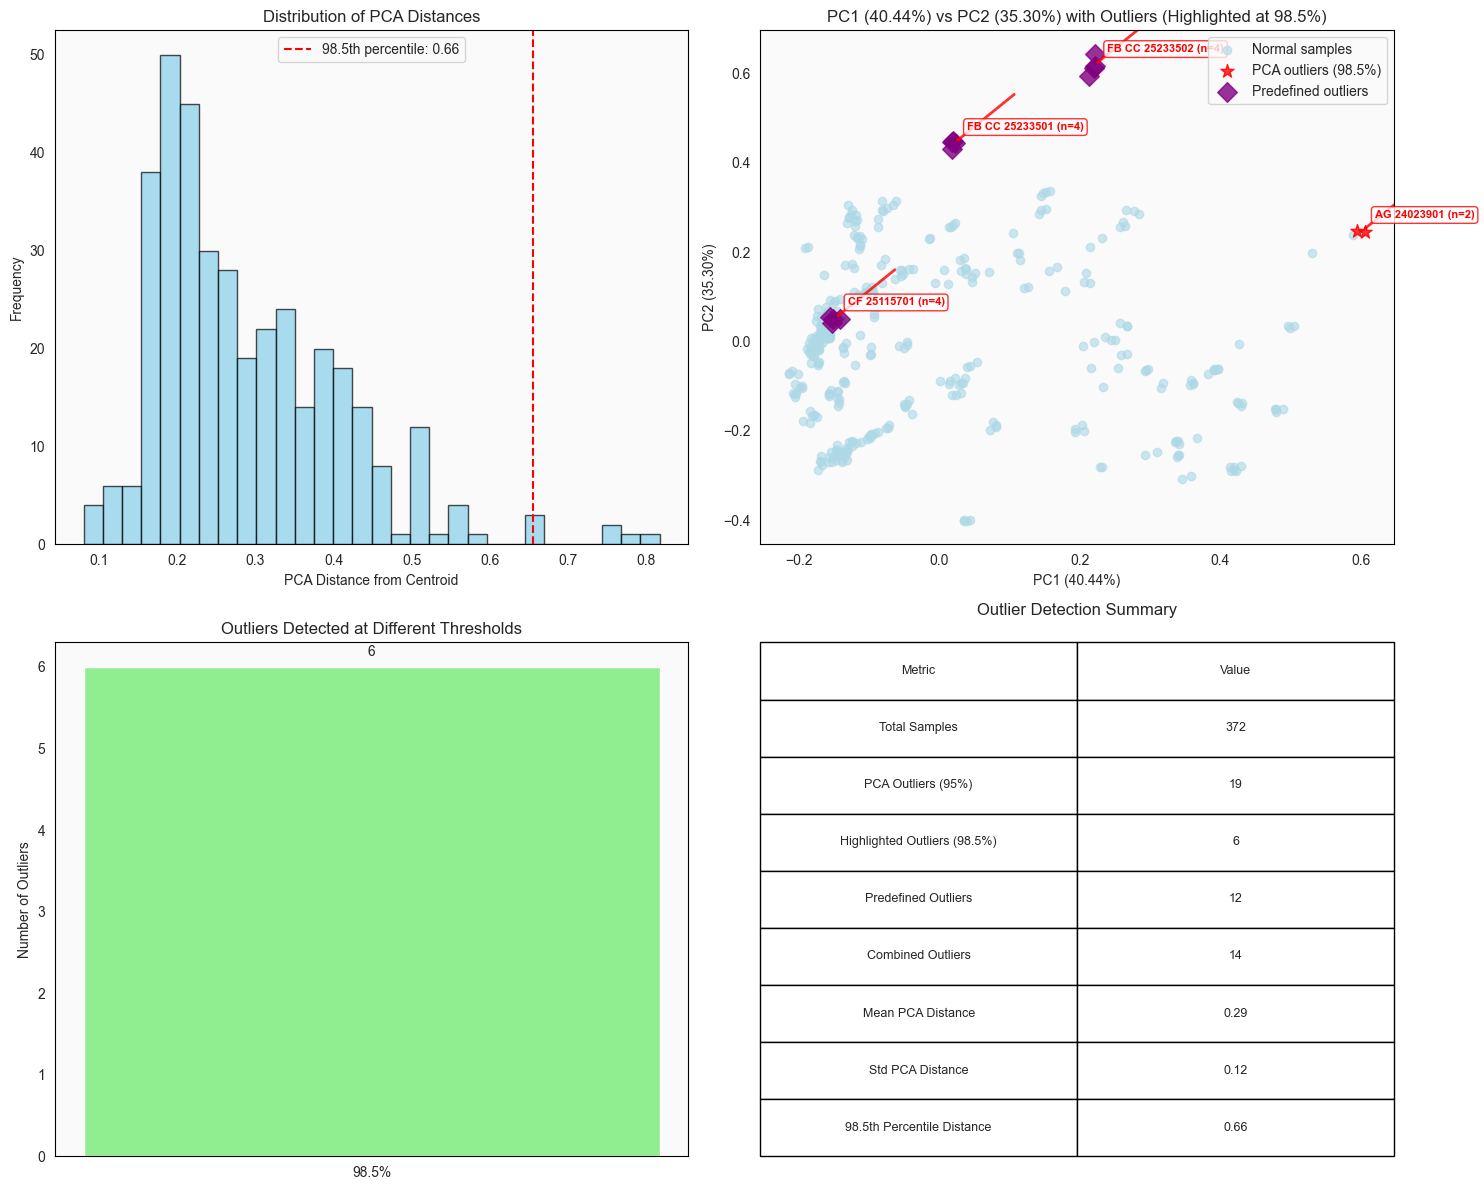


--- Outlier Details ---
Lot ID     Lot Name        Set      PCA Distance Type        
----------------------------------------------------------------------
99744      FB CC 25233502  new      0.817        Predefined  
99744      FB CC 25233502  new      0.782        Predefined  
99744      FB CC 25233502  new      0.759        Predefined  
99744      FB CC 25233502  new      0.747        Predefined  
77713      AG 24023901     train    0.669        PCA-based   
77713      AG 24023901     train    0.659        PCA-based   
99743      FB CC 25233501  new      0.565        Predefined  
99743      FB CC 25233501  new      0.561        Predefined  
99743      FB CC 25233501  new      0.559        Predefined  
99743      FB CC 25233501  new      0.550        Predefined  
92949      CF 25115701     new      0.307        Predefined  
92949      CF 25115701     new      0.305        Predefined  
92949      CF 25115701     new      0.305        Predefined  
92949      CF 25115701     new      

In [36]:
# Detailed outlier analysis with configurable thresholds
# USER CONFIGURATION: Specify which outlier thresholds to analyze
# Examples:
#   OUTLIER_THRESHOLDS = [90]        # Only 90th percentile
#   OUTLIER_THRESHOLDS = [95]        # Only 95th percentile  
OUTLIER_THRESHOLDS = [98.5]        # Only 99th percentile
#   OUTLIER_THRESHOLDS = [90, 95]    # Both 90th and 95th percentiles
#   OUTLIER_THRESHOLDS = [95, 99]    # Both 95th and 99th percentiles
#   OUTLIER_THRESHOLDS = [90, 95, 99] # All three percentiles
# OUTLIER_THRESHOLDS = [90, 95]  # Both 90th and 95th percentiles
PRIMARY_THRESHOLD = 95  # The main threshold for detailed analysis and plotting

# NOTE: The scatter plot will highlight outliers using the LOWEST (most lenient) threshold
# from OUTLIER_THRESHOLDS, while the detailed analysis uses PRIMARY_THRESHOLD

# Import required for labeling function
from matplotlib.patches import FancyArrowPatch

for dataset in datasets:
    SAMPLE_TYPE = f'{dataset}'
    print(f'\n=== Detailed Outlier Analysis for {dataset} ===')
    print(f'Analyzing thresholds: {OUTLIER_THRESHOLDS}%, Primary threshold: {PRIMARY_THRESHOLD}%')
    print(f'Highlighting outliers at: {min(OUTLIER_THRESHOLDS)}% (most lenient threshold)')
    
    selected_df = datasets[dataset]['X_all']
    selected_labels = datasets[dataset]['y_all']
    plot_df = datasets[dataset]['plot_df']
    fitted_pc = datasets[dataset]['fitted_pc']
    pc_labels = datasets[dataset]['pc_labels']
    
    # Generate PC dataframe
    pc_df = generate_pc_df(plot_df, fitted_pc, pc_labels, labels=selected_labels[['set']])
    
    # Get PC columns (excluding non-PC columns)
    pc_cols = [col for col in pc_df.columns if col.startswith('PC')]
    
    # Detect outliers with the primary threshold for main analysis
    primary_outlier_mask, pca_distances = detect_pca_outliers(pc_df, n_components=5, outlier_threshold=PRIMARY_THRESHOLD)
    
    # Use the lowest (most lenient) threshold for highlighting outliers in scatter plot
    lowest_threshold = min(OUTLIER_THRESHOLDS)
    highlight_outlier_mask, _ = detect_pca_outliers(pc_df, n_components=5, outlier_threshold=lowest_threshold)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: PCA distance distribution with configurable thresholds
    ax1 = axes[0, 0]
    
    ax1.hist(pca_distances, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    
    # Plot threshold lines based on user configuration
    colors = ['red', 'orange', 'darkred', 'purple', 'brown']
    for i, threshold in enumerate(OUTLIER_THRESHOLDS):
        color = colors[i % len(colors)]
        percentile_value = np.percentile(pca_distances, threshold)
        ax1.axvline(percentile_value, color=color, linestyle='--', 
                    label=f'{threshold}th percentile: {percentile_value:.2f}')
    
    ax1.set_xlabel('PCA Distance from Centroid')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of PCA Distances')
    ax1.legend()
    
    # Plot 2: PC1 vs PC2 with outliers highlighted and labeled (using lowest threshold for highlighting)
    ax2 = axes[0, 1]
    predefined_outliers = pc_df.index.isin(sus_lot_ids)
    combined_outlier_mask = highlight_outlier_mask | predefined_outliers
    
    # Plot normal points
    normal_mask = ~combined_outlier_mask
    normal_data = pc_df.loc[normal_mask]
    ax2.scatter(normal_data[pc_cols[0]], normal_data[pc_cols[1]], 
               alpha=0.6, color='lightblue', label='Normal samples')
    
    # Plot PCA outliers (using lowest threshold for highlighting)
    pca_only_outliers = highlight_outlier_mask & ~predefined_outliers
    if pca_only_outliers.sum() > 0:
        pca_outlier_data = pc_df.loc[pca_only_outliers]
        ax2.scatter(pca_outlier_data[pc_cols[0]], pca_outlier_data[pc_cols[1]], 
                   color='red', s=100, alpha=0.8, marker='*', label=f'PCA outliers ({lowest_threshold}%)')
    
    # Plot predefined outliers
    if predefined_outliers.sum() > 0:
        predefined_outlier_data = pc_df.loc[predefined_outliers]
        ax2.scatter(predefined_outlier_data[pc_cols[0]], predefined_outlier_data[pc_cols[1]], 
                   color='purple', s=100, alpha=0.8, marker='D', label='Predefined outliers')
    
    # Add labels and arrows for outliers (avoiding duplicate labels for same lot)
    if combined_outlier_mask.sum() > 0:
        outlier_data = pc_df[combined_outlier_mask]
        
        # Get unique lot positions for labeling
        current_pc_cols = [pc_cols[0], pc_cols[1]]
        lot_positions = get_unique_lot_positions(outlier_data, selected_labels, current_pc_cols)
        
        # Add arrows and labels for unique lots only
        for lot_name, pos_info in lot_positions.items():
            x_pos = pos_info['x']
            y_pos = pos_info['y']
            sample_count = pos_info['count']
            
            # Calculate offset for arrow to avoid overlap
            x_range = ax2.get_xlim()[1] - ax2.get_xlim()[0]
            y_range = ax2.get_ylim()[1] - ax2.get_ylim()[0]
            
            # Add arrow pointing to the outlier
            arrow = FancyArrowPatch((x_pos + 0.1 * x_range, y_pos + 0.1 * y_range),
                                  (x_pos, y_pos),
                                  arrowstyle='->', 
                                  color='red', 
                                  linewidth=2,
                                  alpha=0.8)
            ax2.add_patch(arrow)
            
            # Add lot name label with sample count if > 1
            label_text = f'{lot_name}' if sample_count == 1 else f'{lot_name} (n={sample_count})'
            ax2.annotate(label_text, 
                        xy=(x_pos, y_pos),
                        xytext=(10, 10), 
                        textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                 edgecolor='red', alpha=0.8),
                        fontsize=8, 
                        color='red',
                        weight='bold')
    
    ax2.set_xlabel(pc_cols[0])
    ax2.set_ylabel(pc_cols[1])
    ax2.set_title(f'{pc_cols[0]} vs {pc_cols[1]} with Outliers (Highlighted at {lowest_threshold}%)')
    ax2.legend()
    
    # Plot 3: Outlier threshold comparison (using configurable thresholds)
    ax3 = axes[1, 0]
    threshold_counts = []
    for threshold in OUTLIER_THRESHOLDS:
        outlier_mask, _ = detect_pca_outliers(pc_df, n_components=5, outlier_threshold=threshold)
        threshold_counts.append(outlier_mask.sum())
    
    # Use different colors for different thresholds
    colors = ['lightgreen', 'orange', 'red', 'purple', 'brown']
    bar_colors = [colors[i % len(colors)] for i in range(len(OUTLIER_THRESHOLDS))]
    
    ax3.bar([f'{t}%' for t in OUTLIER_THRESHOLDS], threshold_counts, color=bar_colors)
    ax3.set_ylabel('Number of Outliers')
    ax3.set_title('Outliers Detected at Different Thresholds')
    for i, count in enumerate(threshold_counts):
        ax3.text(i, count + 0.1, str(count), ha='center', va='bottom')
    
    # Plot 4: Summary table (updated to reflect configurable thresholds)
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Create summary data with dynamic threshold information
    summary_data = [
        ['Total Samples', len(pc_df)],
        [f'PCA Outliers ({PRIMARY_THRESHOLD}%)', primary_outlier_mask.sum()],
        [f'Highlighted Outliers ({lowest_threshold}%)', highlight_outlier_mask.sum()],
        ['Predefined Outliers', predefined_outliers.sum()],
        ['Combined Outliers', combined_outlier_mask.sum()],
        ['Mean PCA Distance', f'{pca_distances.mean():.2f}'],
        ['Std PCA Distance', f'{pca_distances.std():.2f}']
    ]
    
    # Add percentile information for each configured threshold
    for threshold in OUTLIER_THRESHOLDS:
        percentile_value = np.percentile(pca_distances, threshold)
        summary_data.append([f'{threshold}th Percentile Distance', f'{percentile_value:.2f}'])
    
    table = ax4.table(cellText=summary_data,
                     colLabels=['Metric', 'Value'],
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    ax4.set_title('Outlier Detection Summary', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed outlier information
    if combined_outlier_mask.sum() > 0:
        print(f"\n--- Outlier Details ---")
        outlier_indices = pc_df.index[combined_outlier_mask]
        
        # Create outlier summary
        outlier_data = []
        for i, idx in enumerate(outlier_indices):
            lot_name = selected_labels.loc[idx, 'lot_name'].iloc[0] if hasattr(selected_labels.loc[idx, 'lot_name'], 'iloc') else selected_labels.loc[idx, 'lot_name']
            data_set = selected_labels.loc[idx, 'set'].iloc[0] if hasattr(selected_labels.loc[idx, 'set'], 'iloc') else selected_labels.loc[idx, 'set']
            pca_dist = pca_distances[combined_outlier_mask][i]
            outlier_type = 'Predefined' if idx in sus_lot_ids else 'PCA-based'
            outlier_data.append([idx, lot_name, data_set, pca_dist, outlier_type])
        
        # Sort by PCA distance (descending)
        outlier_data.sort(key=lambda x: x[3], reverse=True)
        
        # Print formatted table
        print(f"{'Lot ID':<10} {'Lot Name':<15} {'Set':<8} {'PCA Distance':<12} {'Type':<12}")
        print("-" * 70)
        for row in outlier_data:
            print(f"{row[0]:<10} {row[1]:<15} {row[2]:<8} {row[3]:<12.3f} {row[4]:<12}")
            
    else:
        print("No outliers detected.")